In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools 
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from scipy import stats
import datajoint as dj
from collections import defaultdict
import pycircstat as pycs
from tqdm import tqdm
import scipy.stats as stats


In [3]:
pinky = dj.create_virtual_module('pinky', 'microns_pinky')
ndap100 = dj.create_virtual_module('pinky_nda', 'microns_pinky_nda')
radtune = dj.create_virtual_module('pinky_radtune', 'microns_pinky_radtune')
spattune = dj.create_virtual_module('pinky_spattune', 'microns_pinky_spattune')
fc = dj.create_virtual_module('pinky_fc', 'microns_pinky_fc')


Connecting celiib@10.28.0.34:3306


In [4]:
# segments that have dendrite verteces > restriction threshold

dendrite_labels = ["Apical","Basal","Oblique","Dendrite"]

#dj.U("segment_id").aggr(pinky.CompartmentFinal.ComponentFinal() & [dict(compartment_type=x) for x in dendrite_labels]
#pinky.CompartmentFinal.ComponentFinal() & [dict(compartment_type=x) for x in dendrite_labels] & "n_vertex_indices>500"
excitatory = dj.U("segment_id").aggr(pinky.CompartmentFinal.ComponentFinal() & [dict(compartment_type=x) for x in dendrite_labels] & "n_vertex_indices>500",
                       dendrite_vertex_count="sum(n_vertex_indices)")

orphan = dj.U("segment_id").aggr(pinky.CompartmentOrphan.ComponentOrphan() & [dict(compartment_type=x) for x in dendrite_labels] & "n_vertex_indices>500",
                       dendrite_vertex_count="sum(n_vertex_indices)")

restriction_threshold = 15000
dendrite_restriction = ((excitatory & "dendrite_vertex_count >" + str(restriction_threshold)).proj() + 
                            (orphan & "dendrite_vertex_count >" + str(restriction_threshold)).proj())

dendrite_restriction

segment_id segment id unique within each Segmentation
648518346341371119
648518346349386137
648518346349470171
648518346349471156
648518346349471500
648518346349471562
648518346349471565
648518346349471910
648518346349472574
648518346349472601


In [7]:
# Exclude synapses, segments and restrict by functional confidence 

contact = pinky.SkeletonContact & pinky.CurrentSegmentation
synapse = (pinky.Synapse - pinky.SynapseExclude) & pinky.CurrentSegmentation

segment = (pinky.Segment - pinky.SegmentExclude) & pinky.CurrentSegmentation
soma = (pinky.AllenSoma - pinky.SegmentExclude) & pinky.CurrentSegmentation

## Orientation / Direction / Von fit correlation

In [8]:
# obtain a list of all keys in fc.ContactCorrelation
df = pd.DataFrame(fc.ContactCorrelation.fetch())
attrs = []
for col in df.columns:
    attrs.append(str(col))


AttributeError: module 'pinky' has no attribute 'ContactCorrelation'

In [8]:
tuned = 'confidence > 1.0'

rad_units = radtune.BestVonFit.Unit & segment & tuned & 'von_p_value <= 0.001' 

rad_unit_pairs = (rad_units.proj(segment_id1 = 'segment_id') * 
                 rad_units.proj(segment_id2 = 'segment_id')) & 'segment_id1 < segment_id2'

radsyncont_df = pd.DataFrame(((radtune.BestVonCorr & rad_unit_pairs) * 
                              fc.ContactCorrelationShaft.proj(*attrs, cont_seg_shared = 'n_seg_shared', cont_seg_union = 'n_seg_union', segment_id1 = 'segment_id', segment_id2 = 'segment_b')).fetch())


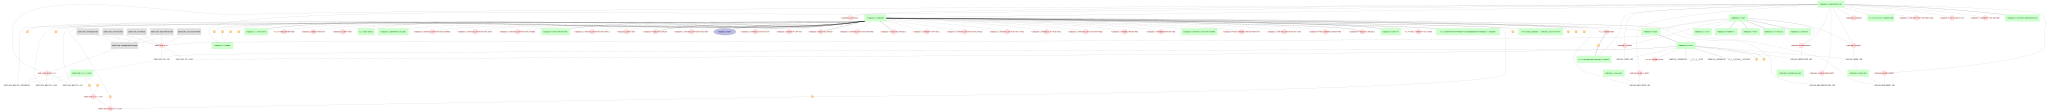

In [21]:
dj.ERD(spattune) -1 +1

In [9]:
# set up bins for difference in prefered orientation 
rad2deg = 180/np.pi
ori_edges = np.linspace(0, np.pi /2 , 5)
oe = list(['{:.0f}'.format(ee) for ee in [np.round(e * rad2deg) for e in ori_edges]])
ori_labels = list(zip(oe[:-1], oe[1:]))
ori_centers = np.round((ori_edges[1:] + ori_edges[:-1])/2 * rad2deg, decimals=2) 

In [10]:
# set up bins for difference in preferred direction
dir_edges = np.linspace(0, np.pi, 5)
de = list(['{:.0f}'.format(ee) for ee in [np.round(e * rad2deg) for e in dir_edges]])
dir_labels = list(zip(de[:-1], de[1:]))
dir_centers = np.round((dir_edges[1:] + dir_edges[:-1])/2 * rad2deg, decimals=2) 

In [11]:
# set up bins for von_corr
vc_edges = np.linspace(min(radsyncont_df['von_corr']), max(radsyncont_df['von_corr']), 7)
ve = list(['{:.1f}'.format(ee) for ee in vc_edges])
vc_labels = list(zip(ve[:-1], ve[1:]))
vc_centers = np.hstack((np.nan, np.round((vc_edges[1:] + vc_edges[:-1])/2, decimals=2), np.nan))

In [12]:
# bin diff_pref_ori, diff_pref_dir, von_corr

radsyncont_df['bin_diff_pref_ori'] = ori_centers[(np.digitize(np.abs(radsyncont_df['diff_pref_ori']), ori_edges)) - 1]
radsyncont_df['bin_diff_pref_dir'] = dir_centers[(np.digitize(np.abs(radsyncont_df['diff_pref_dir']), dir_edges)) - 1]
#radsyncont_df['bin_diff_sharp'] = sharp_centers[(np.digitize(np.abs(radsyncont_df['diff_sharp']), sharp_edges))]
radsyncont_df['bin_von_corr'] = vc_centers[(np.digitize(radsyncont_df['von_corr'], vc_edges))]

In [13]:
# compute n_seg_shared/n_seg_union for both synapse and contact vs functional differences
radsyncont_df['cont_shared_percent'] = radsyncont_df['cont_seg_shared'] / radsyncont_df['cont_seg_union']
radsyncont_df['syn_intersect'] = radsyncont_df['n_seg_a_converted'] + radsyncont_df['n_seg_b_converted'] - radsyncont_df['n_seg_shared_converted']
radsyncont_df['syn_shared_percent'] = radsyncont_df['syn_intersect'] / radsyncont_df['n_seg_shared_converted']

In [23]:
spattune.STABestFitMethod()

stabestfit_method method index,sta_method method index,loc_method method index,shuffle_method method index,stimulus_type imported condition classes,f0 start of included stimulus (stimulus frames preceding trace frame),f1 end of included stimulus (stimulus frames preceding trace frame),description description of method
1,1,2,1,stimulus.Monet,4,0,highest snr


## Receptive field

In [672]:
spat_units = spattune.BestSTA.Loc & 'sta_snr > 1.5' & (segment & (spattune.BestSTA.Confidence() & tuned))
spat_unit_pairs = (spat_units.proj(segment_id1 = 'segment_id') * 
                  spat_units.proj(segment_id2 = 'segment_id')) & 'segment_id1 < segment_id2'
spatsyncont_df = pd.DataFrame(((spattune.BestSTACorr & sig_unit_pairs) * 
                              fc.ContactCorrelationHead.proj(*attrs, cont_seg_shared = 'n_seg_shared', cont_seg_union = 'n_seg_union', segment_id1 = 'segment_id', segment_id2 = 'segment_b')).fetch())


In [576]:
def perc_bins(vals,n_bins): return [np.percentile(vals,p) for p in np.linspace(0,100,n_bins+1)]


In [577]:
# set up percentile bins for union_corr_r2

r2_edges = perc_bins(spatsyncon_df['union_corr_r2'].values, 7)
re = list(['{:.1f}'.format(ee) for ee in r2_edges])
r2_labels = list(zip(re[:-1], re[1:]))
r2_centers = np.hstack((np.nan, np.round((np.array(r2_edges[1:]) + np.array(r2_edges[:-1]))/2, decimals=2), np.nan))


In [673]:
# set up percentile bins for center_dist

dist_edges = perc_bins(spatsyncon_df['center_dist'].values, 7)
de = list(['{:.1f}'.format(ee) for ee in r2_edges])
dist_labels = list(zip(de[:-1], de[1:]))
dist_centers = np.hstack((np.nan, np.round((np.array(dist_edges[1:]) + np.array(dist_edges[:-1]))/2, decimals=2), np.nan))
spatsyncont_df['bin_center_dist'] = dist_centers[(np.digitize(spatsyncont_df['center_dist'], dist_edges))]

In [674]:
spatsyncont_df['bin_center_dist'] = dist_centers[(np.digitize(spatsyncont_df['center_dist'], dist_edges))]
spatsyncont_df['bin_union_corr_r2'] = r2_centers[(np.digitize(spatsyncont_df['union_corr_r2'], r2_edges))]
spatsyncont_df['cont_shared_percent'] = spatsyncont_df['cont_seg_shared'] / spatsyncont_df['cont_seg_union']
spatsyncont_df['syn_intersect'] = spatsyncont_df['n_seg_a_converted'] + spatsyncont_df['n_seg_b_converted'] - spatsyncont_df['n_seg_shared_converted']
spatsyncont_df['syn_shared_percent'] = spatsyncont_df['syn_intersect'] / spatsyncont_df['n_seg_shared_converted']

## Plots

In [603]:
spattune.BestSTACorr()

sta_hash1 unique hash for combination of sta analysis methods,sta_hash2 unique hash for combination of sta analysis methods,apert_radius radius of imposed circular aperture (pixels),segmentation segmentation id,segment_id1 segment id unique within each Segmentation,segment_id2 segment id unique within each Segmentation,center_dist absolute distance between fitted centers (pixels),apert_overlap overlap between two apertures (percent full aperture),full_corr_r2 r2 pearson correlation btw all pixels,full_corr_pvalue p value pearson correlation btw all pixels,union_corr_r2 r2 pearson correlation btw pixels in either roi,union_corr_pvalue p value pearson correlation btw pixels in either roi,intersect_corr_r2 r2 pearson correlation btw pixels in both rois,intersect_corr_pvalue p value pearson correlation btw pixels in both rois,align_corr_r2 r2 pearson correlation btw translated apertures,align_corr_pvalue p value pearson correlation btw translated apertures,align_overlap overlap between aligned apertures (percent full aperture),diff_snr difference in sta snr (hash2 - hash1),diff_snr_pvalue difference in sta snr pvalue (hash2 - hash1)
0008a41775a5530bccf218a5cd5202fc,00c38ffd77cd45bd7bfa91451f96769a,20,2,648518346349385433,648518346349473813,2.60431,0.911958,0.0922337,1.3915e-28,0.213592,1.95661e-15,0.215375,1.71023e-13,-0.0589236,0.0376346,0.99074,-0.48113,0.0
0008a41775a5530bccf218a5cd5202fc,019b7cc3eea2eb6ecf79d8a137553d73,20,2,648518346349385433,648518346349479127,2.23607,0.919916,0.052136,3.84899e-10,0.0569482,0.0375519,0.0655421,0.0258527,0.312567,1.28126e-29,0.99074,-0.20915,0.0
0008a41775a5530bccf218a5cd5202fc,0214ea1c8baf4da76b0f007dd34de344,20,2,648518346349385433,648518346349495761,92.0489,0.0,0.0862794,3.32601e-25,0.06264,0.00641967,nan,nan,-0.711298,0.0,0.510887,-1.19192,0.819
0008a41775a5530bccf218a5cd5202fc,02ebdd6665a08bd508620e280f446aba,20,2,648518346349385433,648518346349507175,14.7648,0.531578,-0.0613093,1.79278e-13,-0.161585,3.97294e-12,-0.291852,1.39102e-14,0.489984,0.0,0.99074,-0.59338,0.0
0008a41775a5530bccf218a5cd5202fc,02f53e2efaaa2ec37114adaea3b49290,20,2,648518346349385433,648518346349495660,2.50148,0.916732,-0.185406,0.0,-0.63454,0.0,-0.667206,0.0,-0.523695,0.0,0.99074,-0.49194,0.0
0008a41775a5530bccf218a5cd5202fc,03be4502579ae0608aa872dd944347aa,20,2,648518346349385433,648518346349490796,32.7567,0.0859437,0.0289486,0.000512273,0.165158,4.97175e-16,0.392819,2.60939e-05,-0.199725,1.14463e-12,0.99074,-1.11113,0.54
0008a41775a5530bccf218a5cd5202fc,04bb3616806443fde99b8b51cfd9c921,20,2,648518346349385433,648518346349502858,62.6672,0.0,-0.012891,0.121898,-0.0651866,0.0011198,nan,nan,-0.132787,2.58321e-06,0.99074,-0.78958,0.005


In [604]:
spattune.BestSTACorr.heading

# quantify correlation and difference (hash2-hash1) in hashes characterized in BestSTA
sta_hash1            : varchar(250)                 # unique hash for combination of sta analysis methods
sta_hash2            : varchar(250)                 # unique hash for combination of sta analysis methods
apert_radius         : int                          # radius of imposed circular aperture (pixels)
segmentation         : smallint                     # segmentation id
segment_id1          : bigint unsigned              # segment id unique within each Segmentation
segment_id2          : bigint unsigned              # segment id unique within each Segmentation
---
center_dist=null     : float                        # absolute distance between fitted centers (pixels)
apert_overlap=null   : float                        # overlap between two apertures (percent full aperture)
full_corr_r2=null    : float                        # r2 pearson correlation btw all pixels
full_corr_pvalue=null : float 

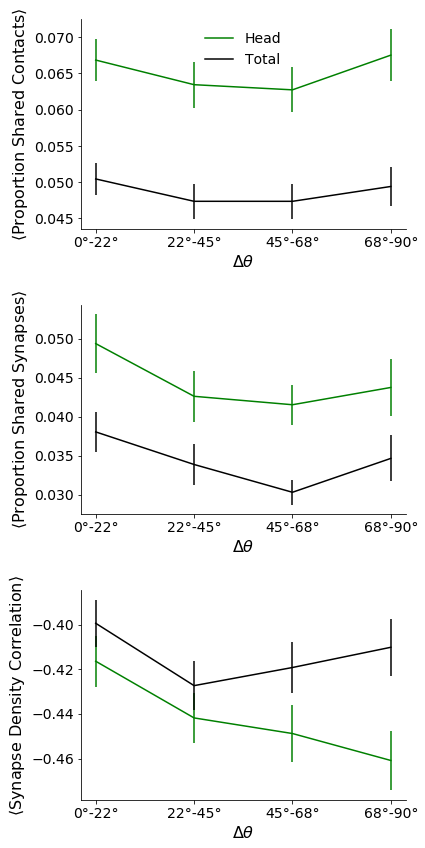

In [602]:
rels = [fc.ContactCorrelationHead, fc.ContactCorrelation]
labels = ['Head', 'Total']
colors = ['g', 'k']
conn = ['cont_shared_percent', 'syn_shared_percent', 'density_pearson_converted']

fig, ax = plt.subplots(3, 1, figsize=(6, 12))
    
for i in range(len(rels)):
    radsyncont_df = pd.DataFrame(((radtune.BestVonCorr & sig_unit_pairs) * 
                              rels[i].proj(*attrs, cont_seg_shared = 'n_seg_shared', cont_seg_union = 'n_seg_union', segment_id1 = 'segment_id', segment_id2 = 'segment_b')).fetch())
    radsyncont_df['bin_diff_pref_ori'] = ori_centers[(np.digitize(np.abs(radsyncont_df['diff_pref_ori']), ori_edges)) - 1]
    radsyncont_df['cont_shared_percent'] = radsyncont_df['cont_seg_shared'] / radsyncont_df['cont_seg_union']
    radsyncont_df['syn_intersect'] = radsyncont_df['n_seg_a_converted'] + radsyncont_df['n_seg_b_converted'] - radsyncont_df['n_seg_shared_converted']
    radsyncont_df['syn_shared_percent'] = radsyncont_df['syn_intersect'] / radsyncont_df['n_seg_shared_converted']
    
    for k in range(len(conn)):
        x_coords = ori_centers
        y_coords = radsyncont_df.groupby('bin_diff_pref_ori').mean()[conn[k]]

        ax[k].plot(x_coords, y_coords, label=labels[i], color=colors[i])
        errors = radsyncont_df.groupby('bin_diff_pref_ori').sem()[conn[k]]  # compute SE
        ax[k].errorbar(x_coords, y_coords, yerr=errors, ecolor=colors[i], fmt=' ', zorder=-1, label=None)
        ax[k].set_xticks(ori_centers)
        ax[k].set_xticklabels(['{}°-{}°'.format(*a) for a in ori_labels])
        ax[k].tick_params(labelsize=14)
        ax[k].set_xlabel(r'$\Delta \theta$', fontsize=16)
        ax[k].spines['top'].set_color('none')
        ax[k].spines['right'].set_color('none')
ax[0].set_ylabel(r'$\langle$Proportion Shared Contacts$\rangle$', fontsize=16)
ax[1].set_ylabel(r'$\langle$Proportion Shared Synapses$\rangle$', fontsize=16)
ax[2].set_ylabel(r'$\langle$Synapse Density Correlation$\rangle$', fontsize=16)
ax[0].legend(loc=9, frameon=False, fontsize=14)
fig.tight_layout()
fig.savefig('figures/cont_syn_density.png', dpi=300)

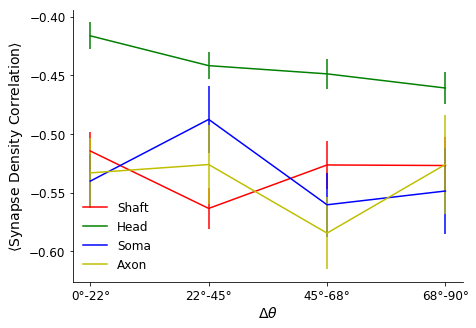

In [650]:
# orientatin tuning 

rels = [fc.ContactCorrelationShaft, fc.ContactCorrelationHead, fc.ContactCorrelationSoma, fc.ContactCorrelationAxon]
labels = ['Shaft', 'Head', 'Soma', 'Axon']
colors = ['r', 'g', 'b', 'y']

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    
for i in range(len(rels)):
    radsyncont_df = pd.DataFrame(((radtune.BestVonCorr & sig_unit_pairs) * 
                              rels[i].proj(*attrs, cont_seg_shared = 'n_seg_shared', cont_seg_union = 'n_seg_union', segment_id1 = 'segment_id', segment_id2 = 'segment_b')).fetch())
    radsyncont_df['bin_diff_pref_ori'] = ori_centers[(np.digitize(np.abs(radsyncont_df['diff_pref_ori']), ori_edges)) - 1]
    
    x_coords = ori_centers
    y_coords = radsyncont_df.groupby('bin_diff_pref_ori').mean()['density_pearson_converted']
    
    ax.plot(x_coords, y_coords, label=labels[i], color=colors[i])

    errors = radsyncont_df.groupby('bin_diff_pref_ori').sem()['density_pearson_converted']  # compute SE
    ax.errorbar(x_coords, y_coords, yerr=errors, ecolor=colors[i], fmt=' ', zorder=-1, label=None)
    
ax.legend(frameon=False, loc=0, fontsize=12)
ax.tick_params(labelsize=12)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_xticks(ori_centers)
ax.set_xticklabels(['{}°-{}°'.format(*a) for a in ori_labels])
ax.set_xlabel(r'$\Delta \theta$', fontsize = 14)
ax.set_ylabel(r'$\langle$Synapse Density Correlation$\rangle$', fontsize = 14)
fig.savefig('figures/density_four_classes.png', dpi=300)

<ErrorbarContainer object of 3 artists>

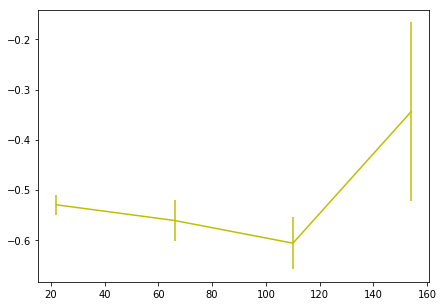

In [656]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(x_coords, y_coords, label=labels[i], color=colors[i])
errors = spatsyncont_df.groupby('bin_center_dist').sem()['density_pearson_converted']  # compute SE
ax.errorbar(x_coords, y_coords, yerr=errors, ecolor=colors[i], fmt=' ', zorder=-1, label=None)
    

In [661]:
dist_labels

[('-0.7', '-0.2'),
 ('-0.2', '-0.1'),
 ('-0.1', '-0.0'),
 ('-0.0', '0.0'),
 ('0.0', '0.1'),
 ('0.1', '0.2'),
 ('0.2', '0.9')]

In [670]:
spat_units = spattune.BestSTA.Loc & 'sta_snr > 1.5' & (segment & (spattune.BestSTA.Confidence() & tuned))
spat_unit_pairs = (spat_units.proj(segment_id1 = 'segment_id') * 
                  spat_units.proj(segment_id2 = 'segment_id')) & 'segment_id1 < segment_id2'

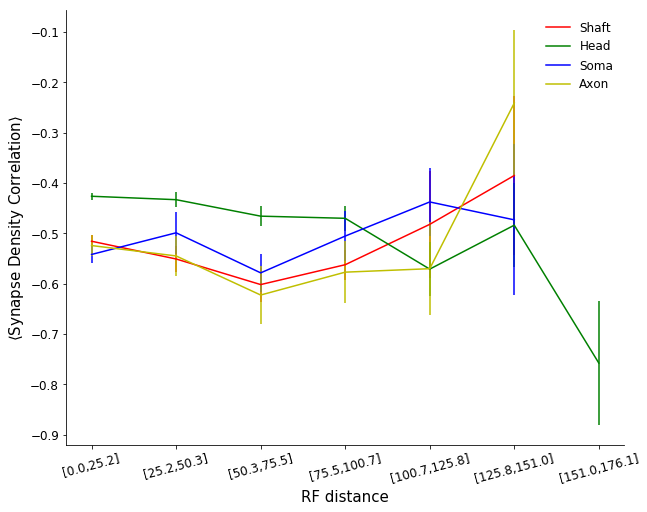

In [671]:
# RF distance

rels = [ta3p100.ContactCorrelationShaft, ta3p100.ContactCorrelationHead, ta3p100.ContactCorrelationSoma, ta3p100.ContactCorrelationAxon]
labels = ['Shaft', 'Head', 'Soma', 'Axon']
colors = ['r', 'g', 'b', 'y']

#rels = [ta3p100.ContactCorrelation]
#labels = ['Total']
#colors = ['k']
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
for i in range(len(rels)):
    spatsyncont_df = pd.DataFrame(((spattune.BestSTACorr & sig_unit_pairs) * 
                              rels[i].proj(*attrs, cont_seg_shared = 'n_seg_shared', cont_seg_union = 'n_seg_union', segment_id1 = 'segment_id', segment_id2 = 'segment_b')).fetch())
    
    dist_edges = np.linspace(min(spatsyncont_df['center_dist']), max(spatsyncont_df['center_dist']), 8)
    de = list(['{:.1f}'.format(ee) for ee in dist_edges])
    dist_labels = list(zip(de[:-1], de[1:]))
    dist_centers = np.hstack((np.nan, np.round((np.array(dist_edges[1:]) + np.array(dist_edges[:-1]))/2, decimals=2), np.nan))
    spatsyncont_df['bin_center_dist'] = dist_centers[(np.digitize(spatsyncont_df['center_dist'], dist_edges))]
    
    x_coords = dist_centers[1:-1]
    y_coords = spatsyncont_df.groupby('bin_center_dist').mean()['density_pearson_converted']
    #print(x_coords, y_coords)
    ax.plot(x_coords, y_coords, label=labels[i], color=colors[i])
    #ax.scatter(x_coords, y_coords, label=labels[i], color=colors[i])

    errors = spatsyncont_df.groupby('bin_center_dist').sem()['density_pearson_converted']  # compute SE
    ax.errorbar(x_coords, y_coords, yerr=errors, ecolor=colors[i], fmt=' ', zorder=-1, label=None)
    
ax.legend(frameon=False, loc=0, fontsize=12)
ax.tick_params(labelsize=12)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_xticks(dist_centers[1:-1])
ax.set_xticklabels(['[{},{}]'.format(*a) for a in dist_labels], rotation=15)
ax.set_xlabel('RF distance', fontsize = 15)
ax.set_ylabel(r'$\langle$Synapse Density Correlation$\rangle$', fontsize = 15)
fig.savefig('figures/RFdistance_density_four_classes.png', dpi=300)

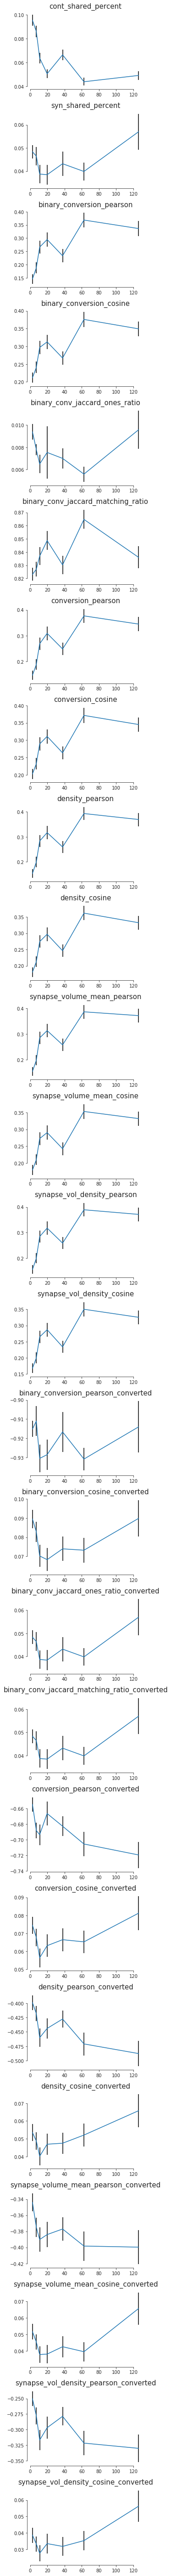

In [675]:
# receptive field

functional = ['bin_center_dist']    
connectomics = ['cont_shared_percent', 'syn_shared_percent', 'binary_conversion_pearson',
       'binary_conversion_cosine', 'binary_conv_jaccard_ones_ratio',
       'binary_conv_jaccard_matching_ratio', 'conversion_pearson',
       'conversion_cosine', 'density_pearson', 'density_cosine',
       'synapse_volume_mean_pearson', 'synapse_volume_mean_cosine',
       'synapse_vol_density_pearson', 'synapse_vol_density_cosine',
       'binary_conversion_pearson_converted',
       'binary_conversion_cosine_converted',
       'binary_conv_jaccard_ones_ratio_converted',
       'binary_conv_jaccard_matching_ratio_converted',
       'conversion_pearson_converted', 'conversion_cosine_converted',
       'density_pearson_converted', 'density_cosine_converted',
       'synapse_volume_mean_pearson_converted',
       'synapse_volume_mean_cosine_converted',
       'synapse_vol_density_pearson_converted',
       'synapse_vol_density_cosine_converted']

with sns.axes_style('ticks'):
    fig, ax = plt.subplots(len(connectomics), len(functional), figsize=(5*len(functional), 3*len(connectomics)))

for i, pair in enumerate(itertools.product(functional, connectomics)):
    #sns.pointplot(pair[0], pair[1], data = spatsyncont_df, ax=ax[i], ci=None) 
    
    x_coords = dist_centers[1:-1]
    y_coords = spatsyncont_df.groupby(pair[0]).mean()[pair[1]] 
    ax[i].plot(x_coords, y_coords)
    
    errors = spatsyncont_df.groupby(pair[0]).sem()[pair[1]]  # compute SE
    ax[i].errorbar(x_coords, y_coords, yerr=errors, ecolor='k', fmt=' ', zorder=-1)
    
    ax[i].set_title(connectomics[i], fontsize=15)

sns.despine(trim=True)
fig.tight_layout()
fig.savefig('figures/Head_union_corr.png', dpi=100)

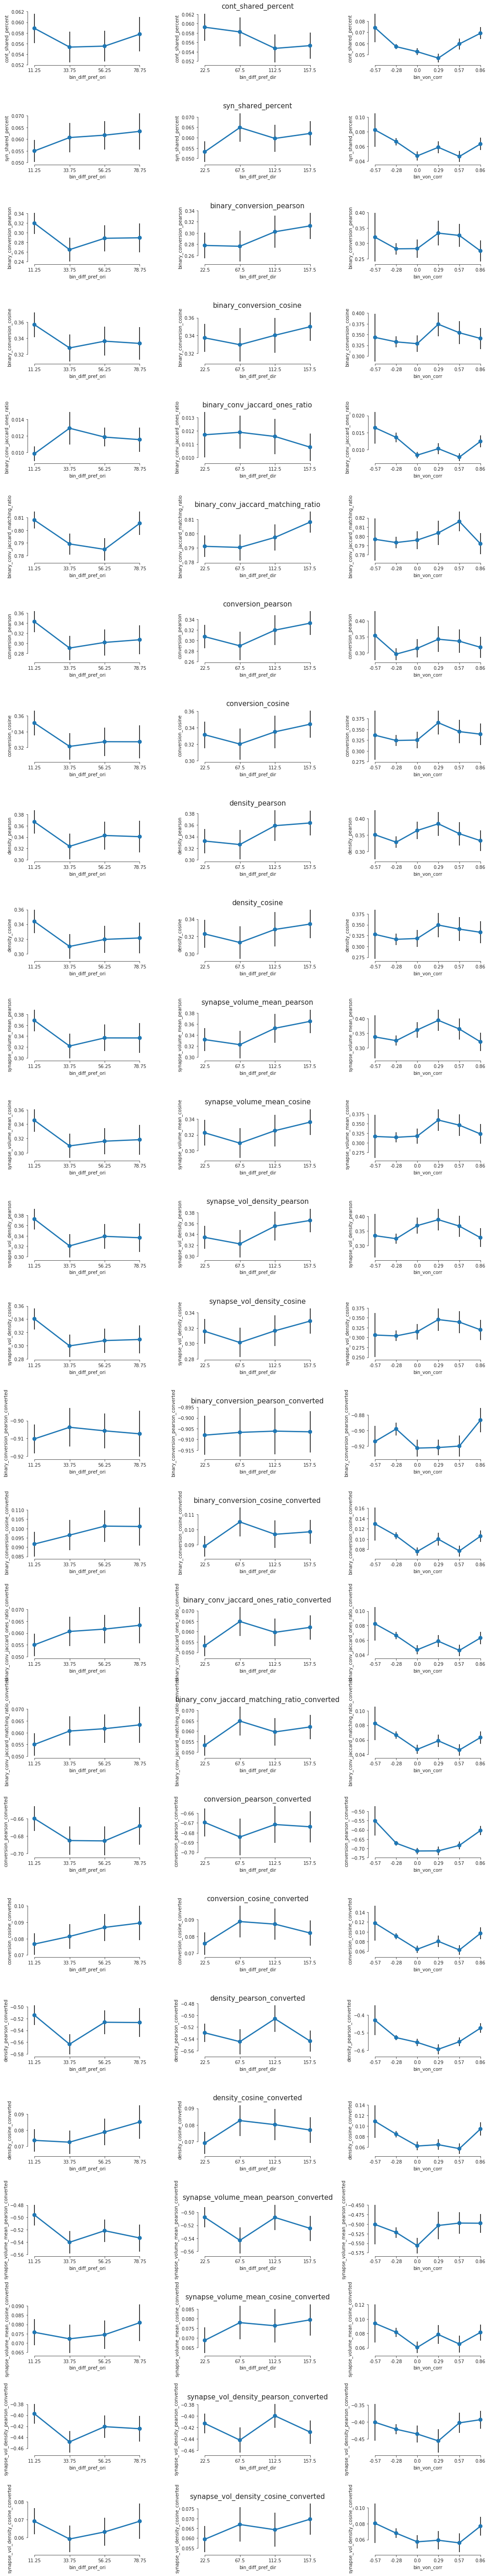

In [540]:
# plot n_seg_shared/n_seg_union for both synapse and contact vs functional differences

functional = ['bin_diff_pref_ori', 'bin_diff_pref_dir', 'bin_von_corr']    
connectomics = ['cont_shared_percent', 'syn_shared_percent', 'binary_conversion_pearson',
       'binary_conversion_cosine', 'binary_conv_jaccard_ones_ratio',
       'binary_conv_jaccard_matching_ratio', 'conversion_pearson',
       'conversion_cosine', 'density_pearson', 'density_cosine',
       'synapse_volume_mean_pearson', 'synapse_volume_mean_cosine',
       'synapse_vol_density_pearson', 'synapse_vol_density_cosine',
       'binary_conversion_pearson_converted',
       'binary_conversion_cosine_converted',
       'binary_conv_jaccard_ones_ratio_converted',
       'binary_conv_jaccard_matching_ratio_converted',
       'conversion_pearson_converted', 'conversion_cosine_converted',
       'density_pearson_converted', 'density_cosine_converted',
       'synapse_volume_mean_pearson_converted',
       'synapse_volume_mean_cosine_converted',
       'synapse_vol_density_pearson_converted',
       'synapse_vol_density_cosine_converted']

with sns.axes_style('ticks'):
    fig, ax = plt.subplots(len(connectomics), len(functional), figsize=(5*len(functional), 3*len(connectomics)))

for i, pair in enumerate(itertools.product(functional, connectomics)):
    sns.pointplot(pair[0], pair[1], data = radsyncont_df, ax=ax[i%len(connectomics), i//len(connectomics)], ci=None) 
    
    # manually plot error bars
    x_coords = []
    y_coords = []
    for point_pair in ax[i%len(connectomics), i//len(connectomics)].collections:
        for x, y in point_pair.get_offsets():
            x_coords.append(x)
            y_coords.append(y)
    errors = radsyncont_df.groupby(pair[0]).sem()[pair[1]]  # compute SE
    
    ax[i%len(connectomics), i//len(connectomics)].errorbar(x_coords, y_coords, yerr=errors, ecolor='k', fmt=' ', zorder=-1)

for i in range(len(connectomics)):
    ax[i, 1].set_title(connectomics[i], fontsize=15)

#sns.pointplot('bin_diff_pref_ori', 'cont_shared_percent', ci=None, data = radsyncont_df, ax=ax[0,0], linestyles='--', color='k')    
#sns.pointplot('bin_diff_pref_dir', 'cont_shared_percent', ci=None, data = radsyncont_df, ax=ax[0,1], linestyles='--', color='k')    
#sns.pointplot('bin_von_corr', 'cont_shared_percent', ci=None, data = radsyncont_df, ax=ax[0,2], linestyles='--', color='k')    
#sns.pointplot('bin_diff_pref_ori', 'syn_shared_percent', ci=None, data = radsyncont_df, ax=ax[1,0], color='k')    
#sns.pointplot('bin_diff_pref_dir', 'syn_shared_percent', ci=None, data = radsyncont_df, ax=ax[1,1], color='k')    
#sns.pointplot('bin_von_corr', 'syn_shared_percent', ci=None, data = radsyncont_df, ax=ax[1,2], color='k')  
'''
l = ['Contact', 'Synapse']
for i in range(2):
    ax[i, 0].set_title('{} percent shared seg vs diff in orientation'.format(l[i]))
    ax[i, 0].set_xticklabels(['{}°-{}°'.format(*a) for a in ori_labels])
    ax[i, 0].set_xlabel(r'$\Delta \theta$')
    ax[i, 0].set_ylabel('$<Shared/Union>$')

    ax[i, 1].set_title('{} percent shared seg vs diff in direction'.format(l[i]))
    ax[i, 1].set_xticklabels(['{}°-{}°'.format(*a) for a in dir_labels])
    ax[i, 1].set_xlabel(r'$\Delta \theta$')
    ax[i, 1].set_ylabel('$<Shared/Union>$')

    ax[i, 2].set_title('{} percent shared seg vs von corr'.format(l[i]))
    ax[i, 2].set_xticklabels(['[{},{}]'.format(*a) for a in vc_labels])
    ax[i, 2].set_xlabel('Von corr')
    ax[i, 2].set_ylabel('$<Shared/Union>$')

'''
sns.despine(trim=True)
fig.tight_layout()
fig.savefig('figures/Head_confidence1.0_percent_shared_seg_by_functional_difference.png', dpi=100)